In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve , plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

In [3]:
df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)

df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

In [4]:
c = df_train.select_dtypes(include=['object']).columns.tolist()

c

['vocal_channel',
 'emotion',
 'emotional_intensity',
 'statement',
 'repetition',
 'sex']

In [5]:
a =[x for x in c if x!='emotion']
a

['vocal_channel', 'emotional_intensity', 'statement', 'repetition', 'sex']

In [7]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in a:
    df_train[i]=le.fit_transform(df_train[i])

for i in a:
    df_test[i]=le.fit_transform(df_test[i])
df_train['emotion']=le.fit_transform(df_train['emotion'])
df_test['emotion']=le.fit_transform(df_test['emotion'])    

In [8]:
le.classes_

array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

In [10]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder

scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="emotion" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex" and n!="filename" and n!="actor"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features


scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test



In [11]:
col=[x for x in df_train.columns if x!="emotion"]
X_train=df_train[col].values
y_train = np.array(df_train["emotion"])

In [12]:
X_test=df_test[col].values
y_test = np.array(df_test["emotion"])

FUNZIONI UTILI 

### LINEAR SVC

In [13]:
from sklearn.svm import LinearSVC


In [15]:
from sklearn.model_selection import GridSearchCV

#Set the parameters by cross-validation
param_grid = {
    'tol':(1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0),
    'loss' : ["hinge", "squared_hinge"],
    'multi_class':["ovr","crammer_singer"]

}
# Set the parameters by cross-validation
grid = GridSearchCV(
    LinearSVC(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # 
    refit=True,
    scoring="f1_macro",
    n_jobs=-1
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_


In [16]:
print(grid.best_params_)

{'C': 0.05, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'tol': 1e-05}


In [19]:
svm = LinearSVC(C = 0.05 ,loss= 'squared_hinge',multi_class='ovr' ,tol = 1e-05)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.55      0.76      0.64        96
           1       0.48      0.64      0.55        96
           2       0.45      0.69      0.54        48
           3       0.61      0.39      0.47        96
           4       0.37      0.39      0.38        96
           5       0.38      0.31      0.34        48
           6       0.42      0.17      0.24        96
           7       0.40      0.44      0.42        48

    accuracy                           0.47       624
   macro avg       0.46      0.47      0.45       624
weighted avg       0.47      0.47      0.45       624



PLOTTIAMO GRAFICI

In [20]:
def print_confMatrix(y_test,y_test_pred):
    cm=confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels =le.classes_)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation='vertical',cmap='Greens')
    plt.show()

In [21]:
def print_rocCurve(clf,X_test,y_test):
    y_tmp=clf.predict_proba(X_test)
    plot_roc(y_test, clf.predict_proba(X_test),figsize=(10,6))
    plt.show()

In [22]:
def print_precrecCurve(clf,X_test,y_test):
    plot_precision_recall(y_test, clf.predict_proba(X_test),figsize=(10,7))
    plt.show()

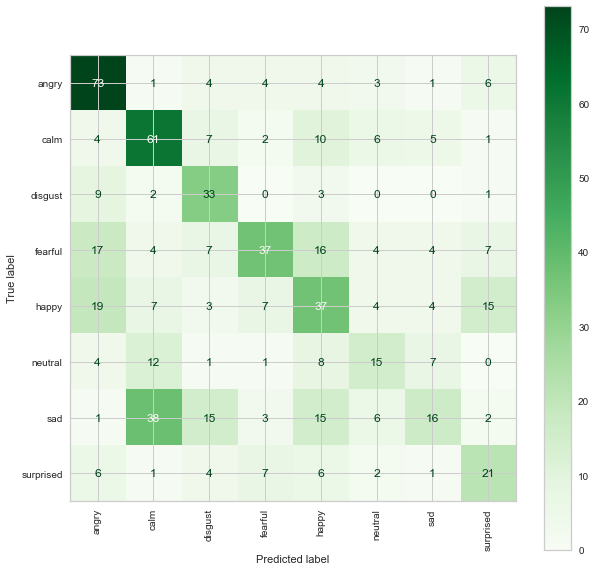

In [23]:
print_confMatrix(y_test,y_pred)

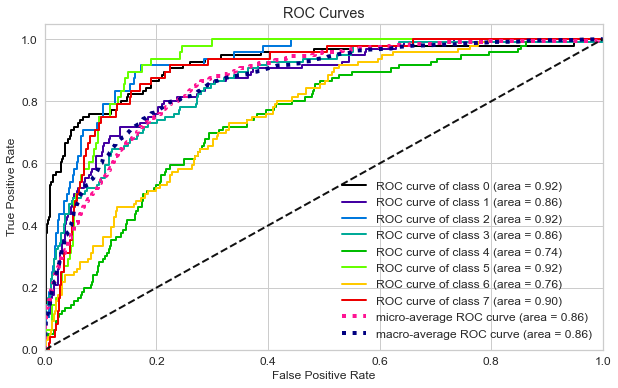

In [24]:
from sklearn.calibration import CalibratedClassifierCV

cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
print_rocCurve(cclf,X_test,y_test)


In [25]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.52      0.64       152
           1       0.67      0.45      0.54       142
           2       0.54      0.50      0.52        52
           3       0.44      0.60      0.51        70
           4       0.40      0.37      0.38       102
           5       0.12      0.29      0.17        21
           6       0.20      0.42      0.27        45
           7       0.40      0.47      0.43        40

    accuracy                           0.47       624
   macro avg       0.45      0.45      0.43       624
weighted avg       0.55      0.47      0.49       624



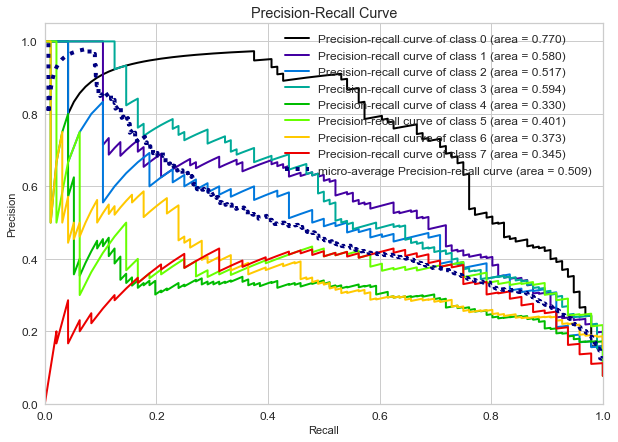

In [26]:
print_precrecCurve(cclf,X_test,y_test)

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

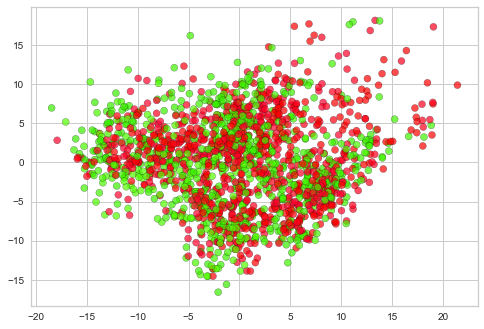

In [29]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Inserire i vettori

NON LINEAR

In [32]:
from sklearn.svm import SVC

# Set the parameters by cross-validation
param_grid = {
    'kernel' : ('linear', 'rbf', 'poly', 'sigmoid'),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0),
    'tol': (1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'decision_function_shape':["ovo", "ovr"]
    }


# Set the parameters by cross-validation
grid = GridSearchCV(
    SVC(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # 
    refit=True,
    scoring="f1_macro",
    n_jobs=-1
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_


In [33]:
print(grid.best_params_)

{'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear', 'tol': 1.0}


              precision    recall  f1-score   support

           0       0.49      0.75      0.60        96
           1       0.46      0.61      0.53        96
           2       0.45      0.56      0.50        48
           3       0.55      0.38      0.45        96
           4       0.41      0.38      0.39        96
           5       0.45      0.48      0.46        48
           6       0.41      0.19      0.26        96
           7       0.55      0.48      0.51        48

    accuracy                           0.47       624
   macro avg       0.47      0.48      0.46       624
weighted avg       0.47      0.47      0.45       624



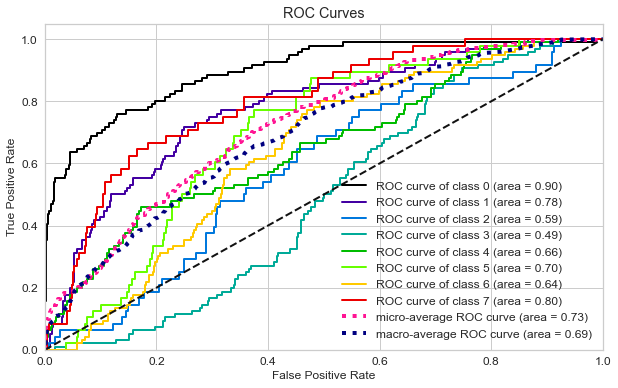

In [55]:
clf = SVC(C = 0.1  , kernel = 'linear', tol = 1.0,decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
print_rocCurve(cclf,X_test,y_test)

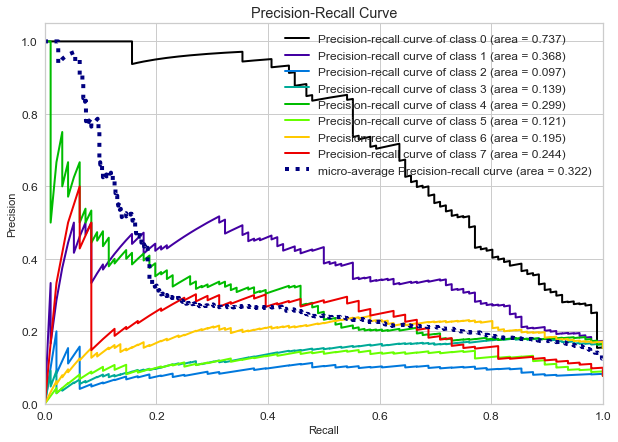

In [35]:
print_precrecCurve(cclf,X_test,y_test)

In [ ]:
print_confMatrix(y_test,y_pred)

In [36]:
support_vectors_pca = pca.transform(clf.support_vectors_)

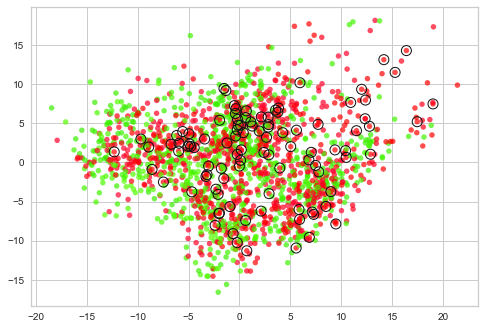

In [37]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

Faccio Unbalanced Learning + Feature selection

In [38]:
from imblearn.under_sampling import TomekLinks
from collections import Counter

In [41]:
from sklearn.tree import DecisionTreeClassifier



In [39]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261, 3: 255, 1: 251, 6: 250, 4: 249, 5: 140, 2: 128, 7: 128})


In [42]:
from sklearn.feature_selection import RFE
sel = RFE(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20), n_features_to_select=22)
X_train_sel = sel.fit_transform(X_res, y_res)
print(f" DT New dimension: {X_train_sel.shape}")
X_test_sel = sel.transform(X_test)

 DT New dimension: (1662, 22)


In [252]:
#print(grid.best_params_)

              precision    recall  f1-score   support

           0       0.66      0.72      0.69        96
           1       0.53      0.73      0.61        96
           2       0.45      0.50      0.48        48
           3       0.62      0.38      0.47        96
           4       0.47      0.42      0.44        96
           5       0.40      0.69      0.50        48
           6       0.51      0.31      0.39        96
           7       0.53      0.54      0.54        48

    accuracy                           0.53       624
   macro avg       0.52      0.54      0.51       624
weighted avg       0.54      0.53      0.52       624



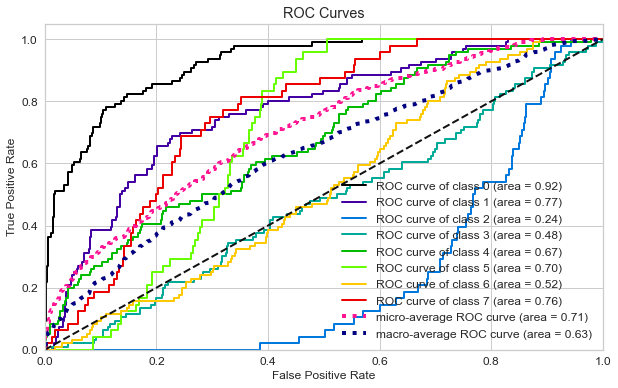

In [56]:
clf = SVC(C = 0.1  , kernel = 'linear', tol = 1.0,decision_function_shape='ovo')
clf.fit(X_train_sel, y_res)
y_pred = clf.predict(X_test_sel)
print(classification_report(y_test,y_pred))
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train_sel, y_res)
y_pred = cclf.predict(X_test_sel)
print_rocCurve(cclf,X_test_sel,y_test)

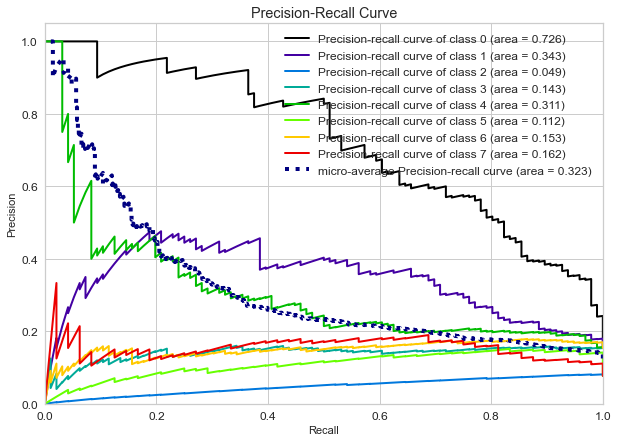

In [57]:
print_precrecCurve(cclf,X_test_sel,y_test)

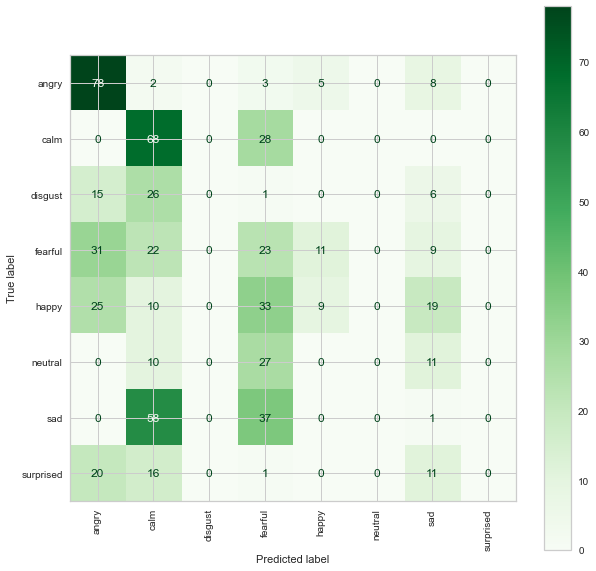

In [58]:
print_confMatrix(y_test,y_pred)

In [47]:
pca = PCA(n_components=2)
pca.fit(X_train_sel)
X_pca = pca.transform(X_train_sel)

In [48]:
support_vectors_pca = pca.transform(clf.support_vectors_)

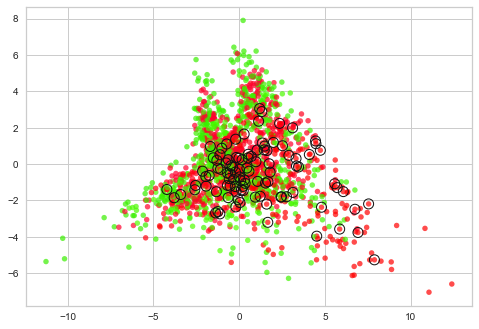

In [49]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [50]:
tmp=[8,249,292,308,309,311,382,554,832,1247,1283,1358,1481,1492,1702,1703,1704,1756,1757,1758,1801]

df_train.drop(tmp,axis=0)

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,...,sc_skew_w4,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,1,5,0,1,0,1,0.018034,0.603864,-0.063106,-0.76930,...,-4.354785,0.161158,-0.925138,2.167997,1.515260,1.079945,0.690192,0.036057,9.400360,-3.035005
1,1,5,0,1,1,1,0.013950,0.603864,-0.063106,-0.76930,...,-0.659640,-0.173413,1.908839,1.610931,0.996435,0.639413,0.409754,0.036057,-0.186504,0.434538
2,1,5,0,0,0,1,0.018855,0.622665,-0.063106,-0.76930,...,-3.086640,-0.286208,-0.925138,1.285119,1.118715,0.877776,0.722854,0.036057,2.891302,-1.463754
3,1,5,0,0,1,1,0.018087,0.603864,-0.063106,-0.76930,...,-0.396009,-0.588962,1.429546,1.176485,0.899140,0.723117,0.560400,0.036057,-0.049566,-0.052845
4,1,1,0,1,0,1,0.015921,0.603864,-0.063106,-0.76930,...,-0.624456,0.170902,0.987370,1.346235,1.065980,0.761301,0.452031,0.036057,0.878701,-0.532241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,1,7,0,0,1,0,-0.019175,0.622665,-0.063106,-0.74864,...,-1.106246,-0.612427,-0.925138,-1.198817,0.514836,0.503321,0.647428,0.036057,1.054354,-1.526104
1824,1,7,1,1,0,0,-0.016770,0.603864,-0.063106,-0.74864,...,-0.901054,-0.871550,-0.925138,-1.198817,-0.484862,0.298852,0.734806,0.036057,-0.389173,-0.504115
1825,1,7,1,1,1,0,-0.025751,0.622665,-0.063106,-0.74864,...,-1.106898,-0.894085,-0.925138,-0.618677,-0.058185,0.167249,0.624605,0.036057,-0.130100,-0.454243
1826,1,7,1,0,0,0,-0.009914,0.603864,-0.063106,-0.70732,...,-0.732249,-0.424644,-0.925138,-1.198817,0.165989,0.375767,0.343780,0.036057,0.072917,-1.058564


In [51]:
col=[x for x in df_train.columns if x!="emotion"]
X_train=df_train[col].values
y_train = df_train["emotion"].values

In [52]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261, 3: 255, 1: 251, 6: 250, 4: 249, 5: 140, 2: 128, 7: 128})


In [53]:
sel = RFE(DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=20), n_features_to_select=22)
X_train_sel = sel.fit_transform(X_res, y_res)
print(f" DT New dimension: {X_train_sel.shape}")
X_test_sel = sel.transform(X_test)

 DT New dimension: (1662, 22)


              precision    recall  f1-score   support

           0       0.66      0.72      0.69        96
           1       0.53      0.73      0.61        96
           2       0.45      0.50      0.48        48
           3       0.62      0.38      0.47        96
           4       0.47      0.42      0.44        96
           5       0.40      0.69      0.50        48
           6       0.51      0.31      0.39        96
           7       0.53      0.54      0.54        48

    accuracy                           0.53       624
   macro avg       0.52      0.54      0.51       624
weighted avg       0.54      0.53      0.52       624



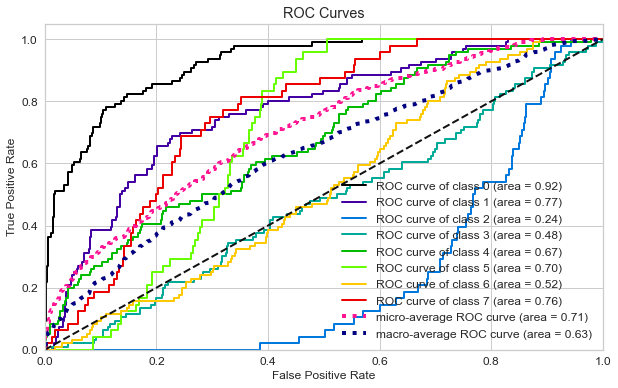

In [59]:
clf = SVC(C = 0.1  , kernel = 'linear', tol = 1.0,decision_function_shape='ovo')
clf.fit(X_train_sel, y_res)
y_pred = clf.predict(X_test_sel)
print(classification_report(y_test,y_pred))
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train_sel, y_res)
y_pred = cclf.predict(X_test_sel)
print_rocCurve(cclf,X_test_sel,y_test)

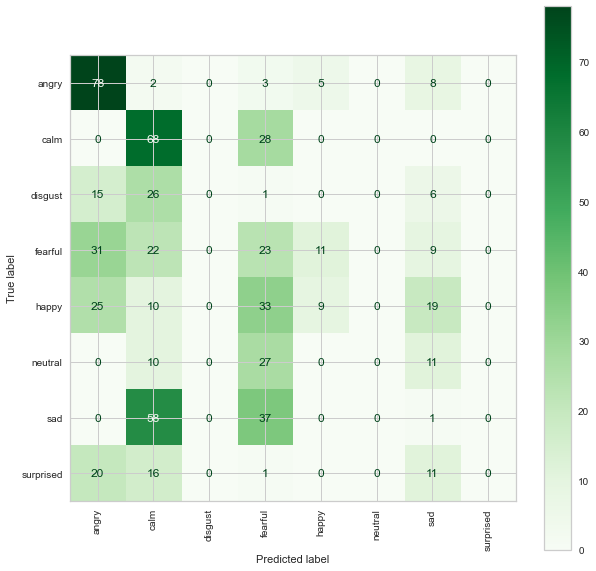

In [60]:
print_confMatrix(y_test,y_pred)

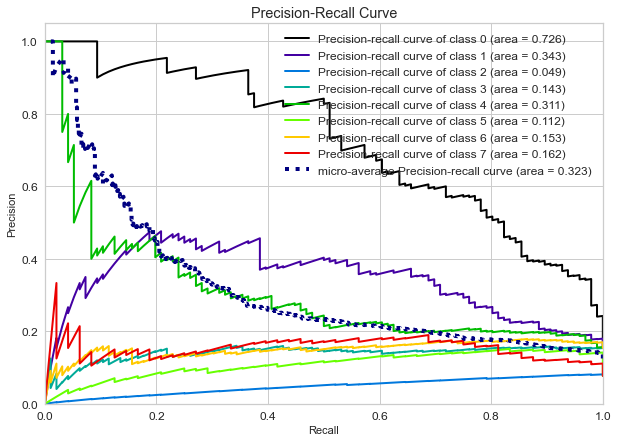

In [61]:
print_precrecCurve(cclf,X_test_sel,y_test)